# Independent Axis Estimation

In this notebook, the Independent Axis Estimation (IAE) algorithm will be implemented and applied to a simple example scenario. The target is a rectangle moving along the x-Axis, which produces noisy measurements from the entire object surface.

Note that the definition of the algorithm is not given in the tutorial paper. This notebook follows the [original paper](https://ieeexplore.ieee.org/document/8916660) by Felix Govaers: 
```
F. Govaers, "On Independent Axes Estimation for Extended Target Tracking," 2019 Sensor Data Fusion: Trends, Solutions, Applications (SDF), 2019, pp. 1-6, doi: 10.1109/SDF.2019.8916660.
```

**TODO** Problems:
- c_plus can go negative
    - with small c_minus values apparantly
    - check everything again regarding that
    - maybe add a hard coded lower bound like 0.1 or something, same for the axis? (kolja did this in his code)

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from scipy.linalg import sqrtm
from copy import copy

# --- Matplotlib settings:
plt.rc('legend', fontsize=10, handlelength=2)  # legend size
plt.rc('font', size=12)  # fontsize

# colors:
c_gt = 'g'  # color for ground truth
c_meas = 'purple'  # color for measurements
c_est = 'b'  # color for estimates

## Generate Data

In this section, the measurement data for the scenario will be generated.

First, global variables regarding the target object and measurements will be set.

In [2]:
# --- object: 
object_center_x = 0
object_center_y = 0
object_length = 3  # x axis
object_width = 2 # y axis

# gt_x array will contain x,y,length, width concat. objects
gt_x_array = []

# object moves along x axis, increase relevant x vairable by velocity after each step:
velocity_x = 0.2
# --- measurements:
# mean number of detections y from the object in each step 
lambda_y = 15
# each true measurement source y will be a 2D vector containing x- and y-position
# covariance of p(z|y) = N(z; y, R)
R = np.eye(2)*0.1 

# --- ensure format of parameters is correct
assert R.shape == (2,2), "R needs to be of shape (2,2)"

# --- set up global constants for implementation
N_STEPS = 10  # how many steps to run the simulation for
RNG = default_rng(42)  # numpy random generator 

---
Next, the corresponding measurements will be created, by first sampling a measurement source anywhere on the object surface and afterwards adding gaussian noise to generate the measurements which will later be passed to the IAE Algorithm.


In [3]:
def random_rect_surface(center_x, center_y, length, width, n_pts):
    """
    Given center, length and width of an axis-aligned rectangle, generate n_pts many points from its surface without noise.
    Creates two arrays of length n_pts: One with random x-coordinates in the rectangle, and a second one with random y-Coordinates.
    """
    xs = RNG.uniform(low=center_x - length / 2, high=center_x + length / 2, size=n_pts)
    ys = RNG.uniform(low=center_y - width / 2, high=center_y + width / 2, size=n_pts)
    return np.array(xs), np.array(ys)

# ---
# Use the above function to generate measurements:
# ---
    
y = []  # measurement sources
z_list = []  # received measurements
# use the above function to draw the corresponding measurements
for i in range(N_STEPS):
    if len(gt_x_array) == 0:
        gt_x_array.append([object_center_x, object_center_y, object_length, object_width])
    else:
        gt_x_array.append(copy(gt_x_array[-1]))
        gt_x_array[-1][0] += velocity_x
    gt_x = gt_x_array[i]
    n_measurements = RNG.poisson(lam=lambda_y)  # number of sources is poisson distributed with mean as specified above
    
    # IAE requires a minimum number of measurements to estimate the spread matrix:
    n_measurements = max(5, n_measurements)
    
    y_pos_x, y_pos_y = random_rect_surface(gt_x[0], gt_x[1], gt_x[2], gt_x[3], n_pts=n_measurements)  # get measurement source
    
    y_i = np.vstack([y_pos_x, y_pos_y]).T  #  current measurement sources to y, in shape (n_measurements, 2)
    y.append(y_i)
    # second: draw measurements z_i from y_i
    z_i = []
    for y_i_k in y_i:  # treat each measurement k = 0...n_measurements-1 independently
        z_i_k = RNG.multivariate_normal(mean=y_i_k, cov=R)  # p(z|y) = N(z; y, R)
        z_i.append(z_i_k)
    z_i = np.array(z_i)
    assert z_i.shape == y_i.shape, "Mismatch between z and y shape"
    z_list.append(z_i)
    
    print("Step: {}/{} - Number of Measurements generated: {}".format(i+1, N_STEPS, n_measurements))

Step: 1/10 - Number of Measurements generated: 18
Step: 2/10 - Number of Measurements generated: 12
Step: 3/10 - Number of Measurements generated: 13
Step: 4/10 - Number of Measurements generated: 21
Step: 5/10 - Number of Measurements generated: 7
Step: 6/10 - Number of Measurements generated: 15
Step: 7/10 - Number of Measurements generated: 14
Step: 8/10 - Number of Measurements generated: 19
Step: 9/10 - Number of Measurements generated: 15
Step: 10/10 - Number of Measurements generated: 17


---
#### Visualize Measurements

In order to visualize the measurement, it is first necessary to define some necessary functions for plotting.

Afterwards, each time step can be visualized individually.

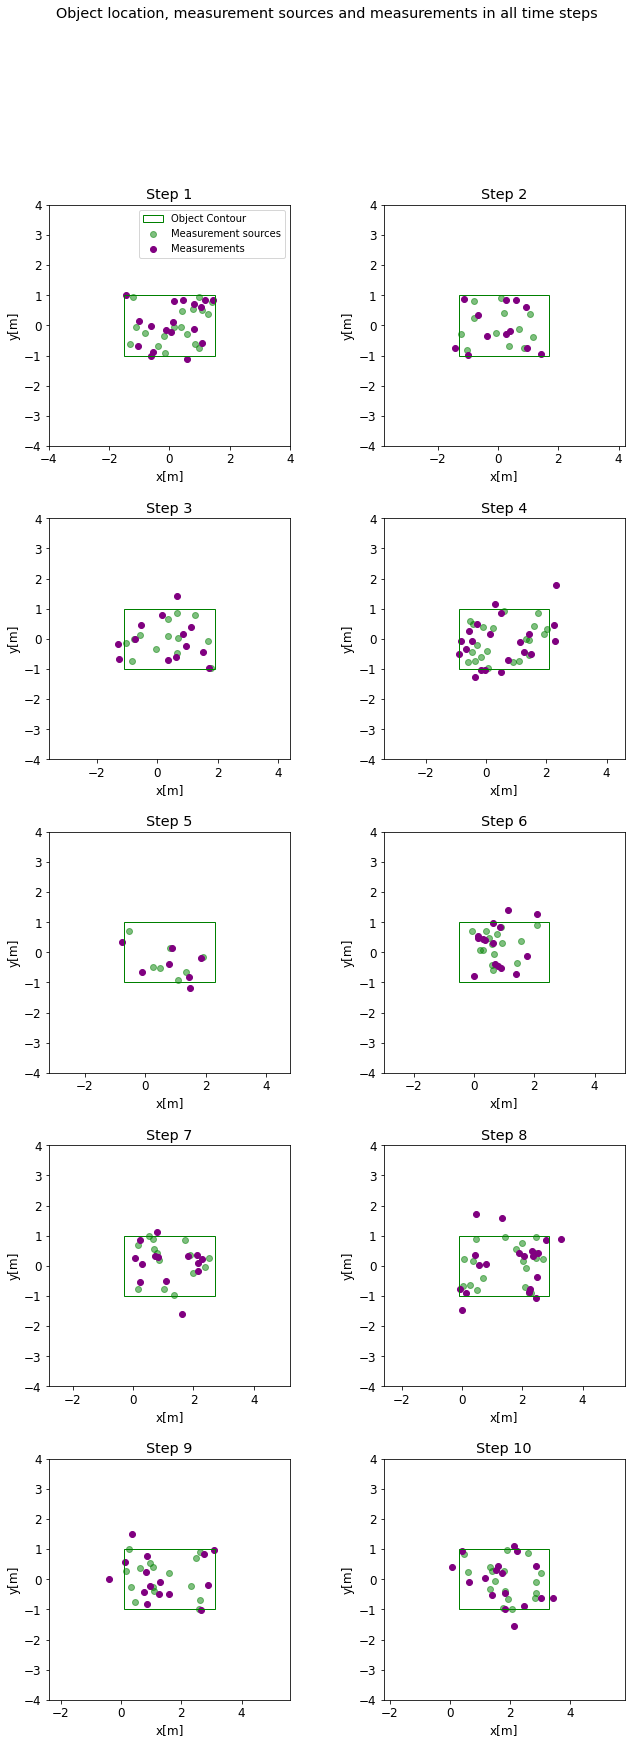

In [4]:
def plt_square(loc, l, ax=None, label_as_m=True):
    """
    Helper function to quickly focus a plot on a location loc with margins l to all sides.
    Can either pass an axis object, or uses the current axis (plt.gca())
    By default also sets axis labeling to 'x[m]' and 'y[m]'
    """
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(loc[0] - l, loc[0] + l)
    ax.set_ylim(loc[1] -l, loc[1] + l)
    ax.set_aspect('equal', adjustable='box')
    
    if label_as_m:
        ax.set_xlabel("x[m]")
        ax.set_ylabel("y[m]")

fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    gt_x = gt_x_array[i]
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor='g', facecolor='none', label="Object Contour")
    ax.add_patch(patch_ground_truth)
    ax.set_title("Step {}".format(i+1))
    ax.scatter(y[i][:, 0], y[i][:, 1], c=c_gt, label="Measurement sources", alpha=0.5)
    ax.scatter(z_list[i][:, 0], z_list[i][:, 1], c=c_meas, label="Measurements")
    
    plt_square(gt_x[:2], 4, ax)
    
    if i == 0:
        ax.legend()
plt.suptitle("Object location, measurement sources and measurements in all time steps")
plt.show()

## Independent Axis Estimation

In the following section, the IAE algorithm will be implemented. 

First, necessary variables will be defined, followed by the _predict_ and _update_ functions of the algorithm. Finally, the previously generated data will be passed to the algorithm, and results will be visualized.

In [5]:
# --- DEFINE VARIABLES
t = 1  # time step length

# IAE Parameters
q_c = 0  # Noise parameter modeling object size change over time. Set to 0 due to fixed object size.
c_scaling = 1/3

# General Parameters:
# F: Motion model
F = np.array([
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
# Q: Covariance of Process noise of the Object motion
Q = 0.0001*np.eye(4)

# H: Measurement Matrix:
H = np.block([np.eye(2), np.zeros((2,2))])

In [6]:
def Rot(alpha):
    """
    Constructs a rotation matrix for given angle alpha.
    """
    r = np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]
    ])
    return r

In [7]:
def predict_iae(x_minus, P_minus, l_minus, c_minus):
    """
    Predict function for the IAE algorithm. Parameters:
    x_minus: Prior kinematic state estimate
    P_minus: Prior kinematic state covariance
    l_minus: 2D Array of Estimated semi-axis lengths
    c_minus: 2D Arrayof semi-axis length variances.
    """
    x_minus = np.array(x_minus)
    P_minus = np.array(P_minus)
    l_minus = np.array(l_minus)
    c_minus = np.array(c_minus)
    x_plus = F @ x_minus
    P_plus = F @ P_minus @ F.T + Q
    l_plus = l_minus
    # q_c: defined in "VARIABLES" section above
    c_plus = c_minus + q_c
    return x_plus, P_plus, l_plus, c_plus

def update_iae(Z, x_minus, P_minus, l_minus, c_minus):
    """
    Update ('filtering') function for the IAE algorithm. Parameters:
    Z: measurements
    x_minus: Prior kinematic state estimate
    P_minus: Prior kinematic state covariance
    l_minus: 2D Array of Estimated semi-axis lengths
    c_minus: 2D Array of semi-axis length variances.
    """
    x_minus = np.array(x_minus)
    P_minus = np.array(P_minus)
    l_minus = np.array(l_minus)
    c_minus = np.array(c_minus)
    
    # (1) Kinematic Update
    n = len(Z)
    z_avg = np.average(Z, axis=0)
    innov = z_avg - H @ x_minus 
    
    alpha = np.arctan2(x_minus[3], x_minus[2])
    L = np.diag(l_minus)
    # R: measurement noise covariance 
    # c: defined in "VARIABLES" section above
    R_bar = (1/n) * (c_scaling * (Rot(alpha) @ L**2 @ Rot(alpha).T) + R)
    S = H @ P_minus @ H.T + R_bar  # innovation covariance
    
    W = P_minus @ H.T @ np.linalg.inv(S)  # gain
    
    # update parameters:
    x_plus = x_minus + W @ innov
    P_plus = P_minus - W @ S @ W.T
    
    # (2) Shape Update
    # measurement observation of half axis length d with corresponding variance v (both as 2D array)
    d, v = half_axis_observation(Z=Z, R_k=R)
    
    s_l = c_minus + v
    w_l = c_minus / s_l
    l_plus = l_minus + w_l * (d - l_minus)
    c_plus = c_minus - w_l**2 / s_l
    return x_plus, P_plus, l_plus, c_plus

def half_axis_observation(Z, R_k):
    """
    Computing the half axis measurement from given sensor data Z and noise with covariance R_k
    Returns the observation of half axis length d with corresponding variance v, each as 2D arrays.
    """
    n = len(Z)
    
    # spread matrix of measurements
    Z_spread = Z - np.average(Z, axis=0).reshape((-1, 2))
    Z_spread = (Z_spread.T @ Z_spread) / (n-1)
    
    # calculation of eigenvalues - note that we use the rescaled version Z
    w, V = np.linalg.eig(Z_spread * (1/c_scaling))
    if w[0] < w[1]:
        # np eig does not ensure ordered return
        # switch if necessary
        sw, sV = w[0], V[:, 0]
        w[0], V[: ,0] = w[1], V[:, 1]
        w[1], V[: ,1] = sw, sV
    
    K = (1/c) * V.T @ R_k @ V
    k = np.diag(K)
    
    d = np.sqrt(w - k) 
    v = np.array([0, 0])
    v = ( (d**2 + k)**2 ) / ( 2*(n-1)*d**2 )
    return d, v

In [8]:
def plot_ellipse_iae(m, l, ax=None):
    """
    Plot the estimated extent of an object described by kinematic state x and semi axis length l according to the IAE definition.
    """
    if ax is None:
        ax = plt.gca()
    l1, l2 = l
    alpha = np.arctan2(m[3], m[2])
    # l1 and l2 are semi-axis length, so double when passing to patches.Ellipse
    # patches.Ellipse takes angle counter-clockwise
    el = patches.Ellipse(xy = m[:2], width=2*l1, height=2*l2, angle=alpha, fill=False, color=c_est, label="Extent Estimate")
    ax.scatter(m[0], m[1], c=c_est, marker='x')
    ax.add_patch(el)

## Apply Algorithm

Given these function, the data from the first section of this notebook can be analysed.

In [9]:
# Initial Values
x_init = [0, 0, 0.2, 0]
P_init = np.eye(4)*0.04
l_init = [1, 1]
c_init = [10, 10]

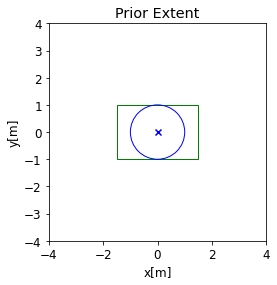

In [10]:
# Take a look at the prior
plt.title("Prior Extent")
gt_x = gt_x_array[0]
patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none')
plt.gca().add_patch(patch_ground_truth)
plot_ellipse_iae(x_init, l_init)
plt_square(gt_x[:2], 4)
plt.show()

In [11]:
# Running the algorithm on the data

# Arrays to store intermediate results:
x_list = []
P_list = []
l_list = []
c_list = []

# Initial values:
x = x_init
P = P_init
l = l_init  # start with a circle
c = c_init

for i in range(N_STEPS):
    # get measurements z_i for this step
    Z = z_list[i]
    
    # predict
    x, P, l, c = predict_iae(x, P, l, c)
    
    # update
    x, P, l, c = update_iae(Z, x, P, l, c)
    x_list.append(x)
    P_list.append(P)
    l_list.append(l)
    c_list.append(c)

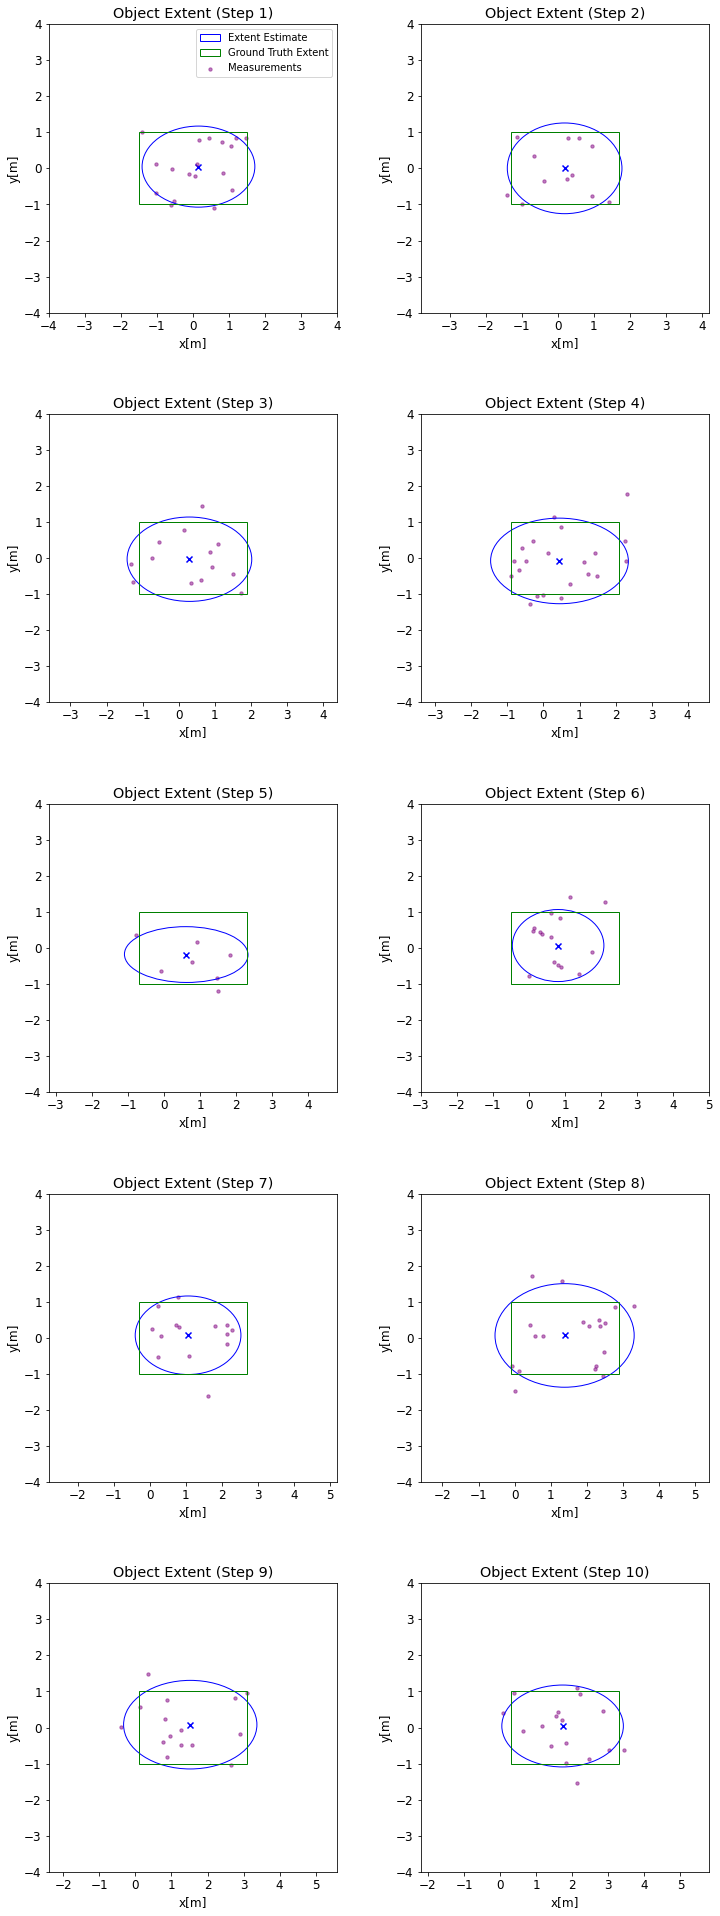

In [12]:
# Visualize each step indivdually:
SIZE = 4  # size parameter for subplots
fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
fig.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    gt_x = gt_x_array[i]
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    # --- EXTENT ESTIMATE:
    plt.sca(ax)
    plot_ellipse_iae(x_list[i], l_list[i])
    
    # add ground truth:
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none', label="Ground Truth Extent")
    ax.add_patch(patch_ground_truth)
    
    # add measurements 
    ax.scatter(z_list[i][:, 0], z_list[i][:, 1], c=c_meas, label="Measurements", alpha=0.5, s=11)
    
    # add title and formatting:
    ax.set_title("Object Extent (Step {})".format(i+1))
    plt_square(gt_x[:2], 4)

    if i == 0:
        ax.legend()
plt.show()